# Timers

There are two types of timers, one-shot timers, and auto-reload timers.

- A one-shot timer can execute its callback function only once. It can be manually re-started, but will not automatically re-start itself.
- Conversely, an auto-reload timer will automatically re-start itself after each execution of its callback function, resulting in periodic callback execution.

- There is a dedicated ‘Tmr Svc‘ (Timer Service or Deamon) Task which maintains an ordered list of software timers, with the timer to expire next in front of the list

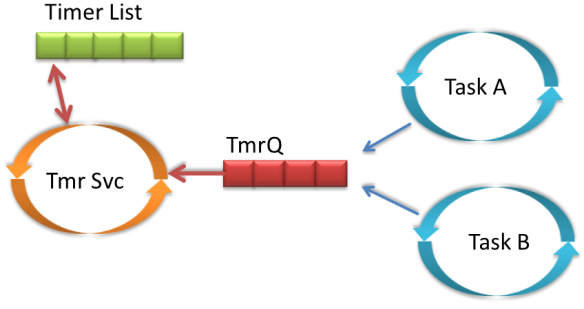

## Timer Task and FreeRTOSConfig.h

    #define configUSE_TIMERS 1

- If you are not using FreeRTOS software timers, set that macro to 0, otherwise your application is using more resources than necessary. Because this creates the ‘Tmr Svc’ task during vTaskStartScheduler()

- The timer task name, priority and stack size can be configured with the following macros in FreeRTOSConfig.h

    #define configTIMER_SERVICE_TASK_NAME "Tmr Svc"
    #define configTIMER_TASK_PRIORITY (configMAX_PRIORITIES - 1)
    #define configTIMER_TASK_STACK_DEPTH (configMINIMAL_STACK_SIZE * 2)

- give the timer task the  highest task priority in the system, otherwise you will see some latency in the timer hook execution.
- The timer stack size really depends on what you are doing in the timer hooks called from the timer task.

## Timer Queue and FreeRTOSConfig.h

- This queue is used for IPC (Inter-Process Communication) between the timer task and the other tasks of the system
- The length of the queue can be configured with the following macro, while the name of the queue “TmrQ” is hard-coded in the RTOS:
    #define configTIMER_QUEUE_LENGTH 10

- what is a useful length for that queue? 
    + Because the longer, the more RAM is used. 
    + Basically the queue needs to hold as many command items which can be sent by other tasks (or interrupts) until they can be served by the Timer Task. 
    + With the Timer task having the highest priority in the system, the queue can be smaller. 
    + But if multiple commands can be sent from higher priority tasks or from interrupts, make sure your queue is long enough for this.

## APIs
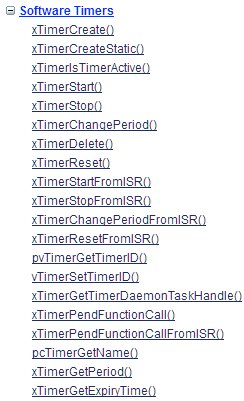





## Creating a Software Timer

### Handle
    xTimerHandle timerHndl1Sec;

### xTimerCreate
    TimerHandle_t xTimerCreate( const char * const pcTimerName,
        const TickType_t xTimerPeriodInTicks,
        const UBaseType_t uxAutoReload,
        void * const pvTimerID,
        TimerCallbackFunction_t pxCallbackFunction )

Example:
```
    timerHndl1Sec = xTimerCreate(
        "timer1Sec", /* name */
        pdMS_TO_TICKS(1000), /* period/time */
        pdTRUE, /* auto reload */
        (void*)0, /* timer ID */
        vTimerCallback1SecExpired); /* callback */
    if (timerHndl1Sec==NULL) {
        for(;;); /* failure! */
    }
```

### Timer Callback

- As the timer callbacks are called from the Timer Service task, it is important that the callback function does not block (e.g. waits for some time or waits for a semaphore), as otherwise all other timers get delayed. 
- So the general rule for a timer callback function (as for interrupt service routines) is: keep it short and simple!

### Starting a Timer
    BaseType_t xTimerStart( TimerHandle_t xTimer, TickType_t xTicksToWait );

- If the timer is started before the scheduler is started, the timer will start to run at scheduler start time.
- If the timer is started say from a task, it starts at the current tick time at which xTimerStart() is called.

### Resetting a Timer

    BaseType_t xTimerReset( TimerHandle_t xTimer, TickType_t xTicksToWait );

### xTimerPendFunctionCall

- A rather special one is xTimerPendFunctionCall(): With that API method I can send to the timer deamon task a callback/function pointer to be called. 
- Basically a ‘dear timer task, please execute this function for me’. 
- This function will be called immediately (and only once) when the timer deamon tasks removes the command from the timer queue.